In [180]:
!pip install qiskit[all]

In [181]:
!pip install qiskit-aer-gpu

In [182]:
from qiskit import __qiskit_version__
print(__qiskit_version__)

{'qiskit-terra': '0.23.2', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.1', 'qiskit': '0.41.1', 'qiskit-nature': '0.5.2', 'qiskit-finance': '0.3.4', 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.5.0'}


In [183]:
!pip install pylatexenc

In [184]:
import json
import time
import warnings

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.algorithms.optimizers import COBYLA, SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.primitives import BackendSampler, Sampler
from qiskit_aer import StatevectorSimulator
from qiskit_aer import AerSimulator

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

from qiskit.utils import algorithm_globals
from qiskit.visualization import array_to_latex

algorithm_globals.random_seed = 1042

np.random.seed(42)


In [185]:
backend = StatevectorSimulator(precision='double')
backend.available_devices()

('CPU', 'GPU')

In [186]:
backend = AerSimulator(method='statevector', precision='double', device = "GPU") 

In [187]:
sampler=Sampler()

In [188]:
sampler.set_options(backend=backend, device='GPU')

In [189]:
sampler.options

Options(backend=AerSimulator('aer_simulator_statevector_gpu'), device='GPU')

# A Quantum Autoencoder

The goal of this is to build an Quantum Autoencoder, a circuit which can compress a quantum state onto a smaller amount of qubits, while retaining the information from the initial state.

We give a digital image compressor example to demonstrate the capabilities of such a system to compress different quantum states, as well as the ability to compress images of labels 0 and 1 of the fashion MNIST dataset.

The Architecture of the Quantum AutoEncoder will be a Raw Feature Vector, a trainable Real Amplitudes ansatz and Swap Test.

### Ansatz Definition

In [190]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

In [191]:
num_qubits = 10
circ = ansatz(num_qubits)


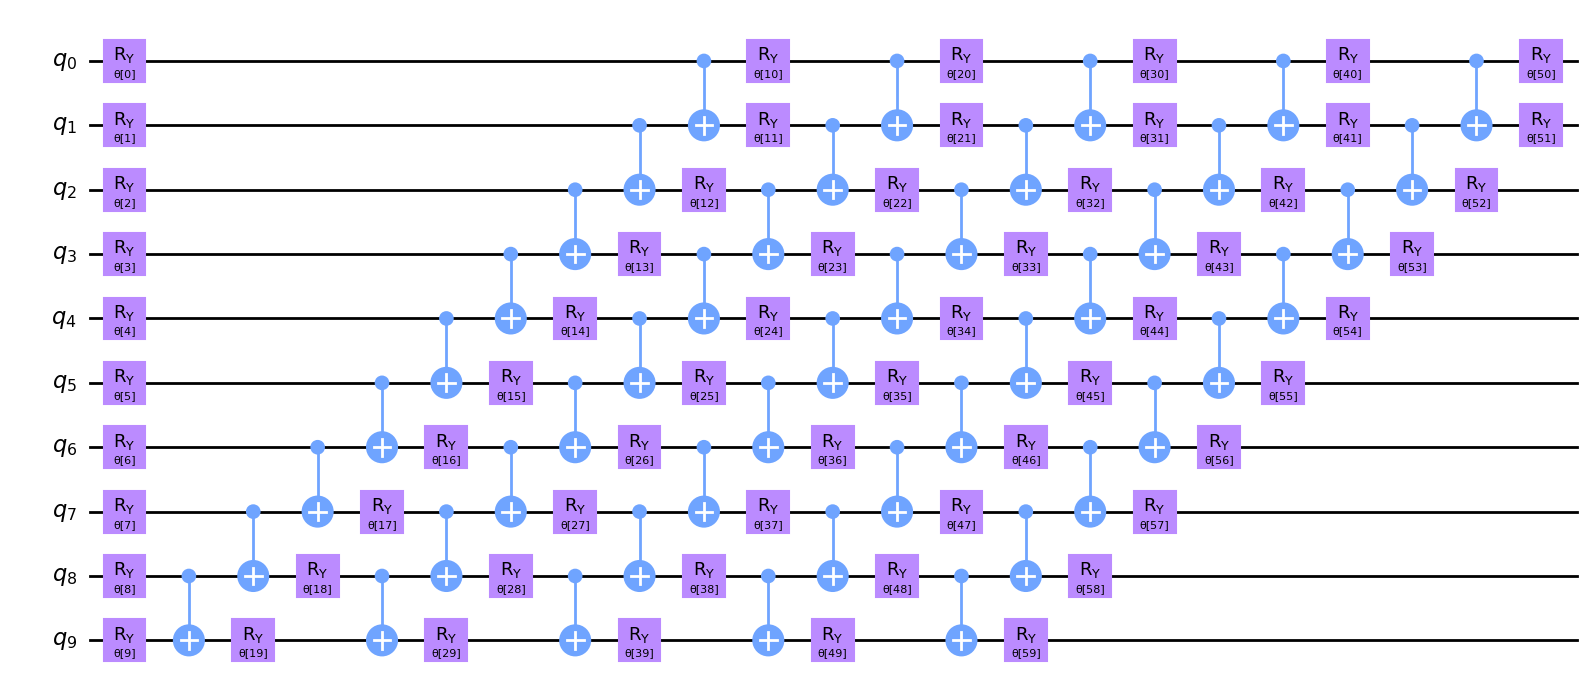

In [192]:
circ.decompose().draw('mpl')

Autoencoder Circuit

In [193]:
def auto_encoder_circuit(num_latent, num_trash):

    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()

    auxiliary_qubit = num_latent + 2 * num_trash

    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)
    circuit.h(auxiliary_qubit)

    circuit.measure(auxiliary_qubit, cr[0])
   
    
    return circuit


num_latent = 4
num_trash = 6
circuit = auto_encoder_circuit(num_latent, num_trash)


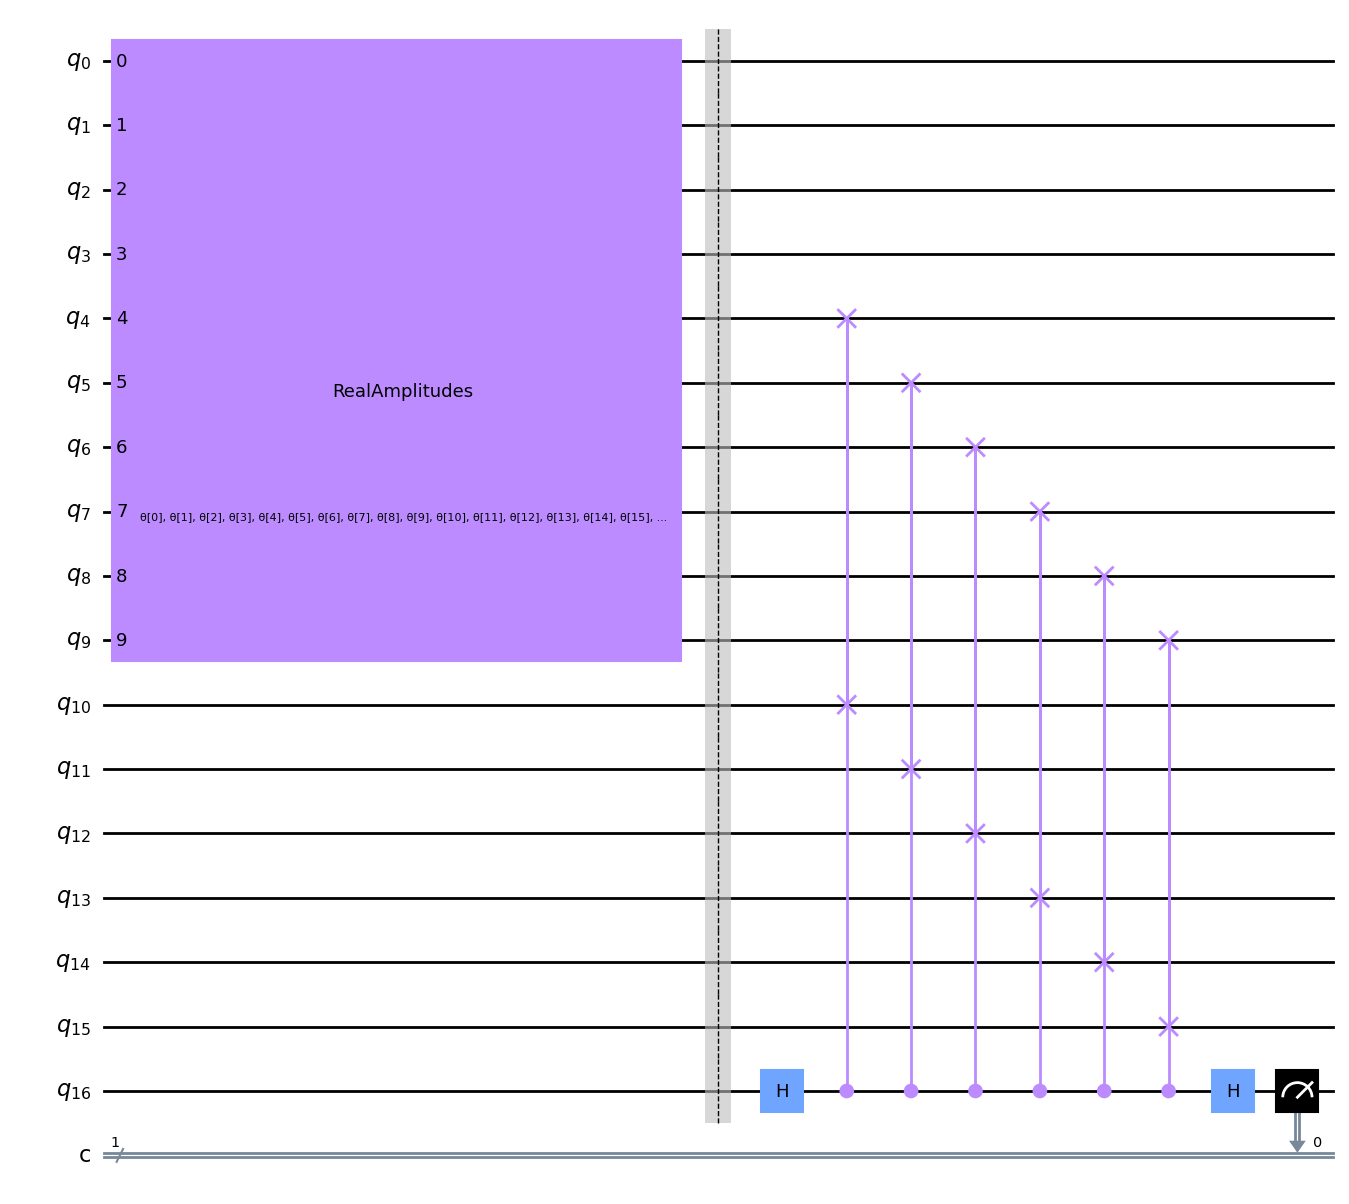

In [194]:
circuit.draw('mpl')

In [195]:
!pip install tensorflow

### Data Import

In [196]:
from tensorflow.keras.datasets import fashion_mnist

In [197]:
data = fashion_mnist.load_data()

In [198]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [199]:
print("Number of training images:", X_train.shape[0])
print("Number of test images:", X_test.shape[0])

Number of training images: 60000
Number of test images: 10000


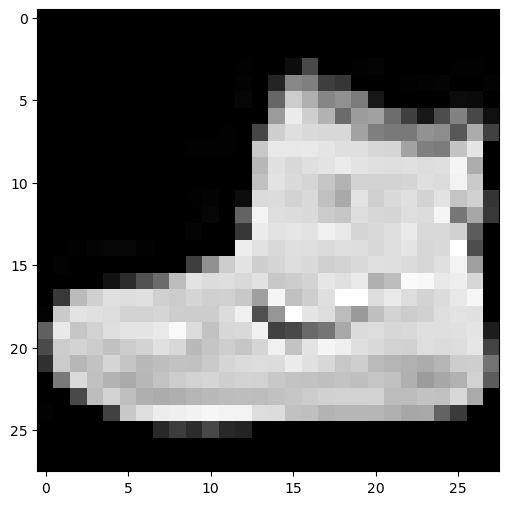

In [200]:
plt.imshow(X_train[0], cmap='gist_gray')
plt.show()

In [240]:
# Filter images and labels with label 0 and 1
filtered_train_idx = (Y_train == 0) | (Y_train == 1)
X_train = X_train[filtered_train_idx]
Y_train = Y_train[filtered_train_idx]

filtered_test_idx = (Y_test == 0) | (Y_test == 1)
X_test = X_test[filtered_test_idx]
Y_test = Y_test[filtered_test_idx]


print("Number of training images:", X_train.shape[0])
print("Number of test images:", X_test.shape[0])
print(f'Labels {set(Y_train)}')

Number of training images: 11950
Number of test images: 2000
Labels {0, 1}


In [202]:
!pip install opencv-python

In [203]:
import cv2

In [204]:
def resizing(imgs):
    return np.array([cv2.resize(img, (32, 32), interpolation=cv2.INTER_LINEAR_EXACT) for img in imgs], dtype='float')


def reshaping(imgs):
    return imgs.reshape(len(imgs), -1)

In [205]:
X_train_resized = resizing(X_train)
X_test_resized = resizing(X_test)

In [206]:
X_train_resized_reshaped = reshaping(X_train_resized)
X_test_resized_reshaped = reshaping(X_test_resized)

### Circuit Composition

In [207]:
num_latent = 4
num_trash = 6

fm = RawFeatureVector(2 ** (num_latent + num_trash))
ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)


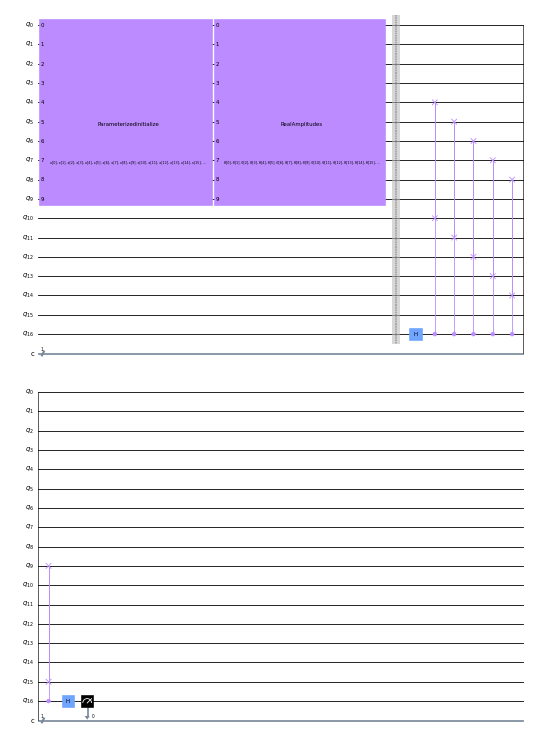

In [213]:
display(qc.draw('mpl', scale=0.3))

In [143]:
circ_score = qc.depth()*qc.width()
circ_score

198

In [144]:
qc.num_parameters, fm.num_parameters, ae.num_parameters

(1084, 1024, 60)

### QNN definition

In [145]:
def interpret(x):
   return x

# QNN Definition
qnn = SamplerQNN(
    sampler=sampler,
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=interpret,
    output_shape=2,
)

### Loss Function

In [146]:
#target one hot encoding
def one_hot_encode(target):
    return np.eye(2)[target]

#Different Loss Functions===========================================================
#Cross Entropy Loss Function
def cross_entropy_loss(prediction, target):
    loss = -np.sum(one_hot_encode(target) * np.log(prediction + 1e-9))
    return loss

# MSE Loss Function
def mse_loss(prediction, target):
    return ((prediction - one_hot_encode(target)) ** 2).mean()

#L2 Normalization MSE Loss Function
def mean_square_error_with_l2(prediction, target, lam=0.1):
    mse = np.mean(np.square(prediction - one_hot_encode(target)))
    l2 = lam * np.sum(np.square(prediction))
    return mse + l2

#L1 Normalization MSE Loss Function
def mean_square_error_L1(prediction, target, weight_decay=0.01):
    diff = prediction - one_hot_encode(target)
    l1_norm = np.sum(np.abs(diff))
    mse = np.mean(diff**2)
    loss = mse + weight_decay * l1_norm
    return loss

# Fidelity State Loss Function
def fidelity_loss(prediction, target):
    print(prediction)
    print(target)
    loss = 1 - state_fidelity(one_hot_encode(target), prediction, validate=False)
    return loss
#=====================================================================================

def loss_func_fashion(params_values):
    probabilities = qnn.forward(X_train_resized_reshaped[0:200], params_values)
    cost = np.sum(probabilities[:, 1]) / 200
    objective_func_vals.append(cost)
    # plotting part
    clear_output(wait=True)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    #plt.text(0, 1.1, f'Fidelity Loss = {cost:.2f}', ha='left',
             #va='bottom', transform=plt.gca().transAxes)
    plt.show()
    return cost

In [147]:
with open("QAE_IP.json", "r") as f:
    initial_point = json.load(f)


### Optimizer Training

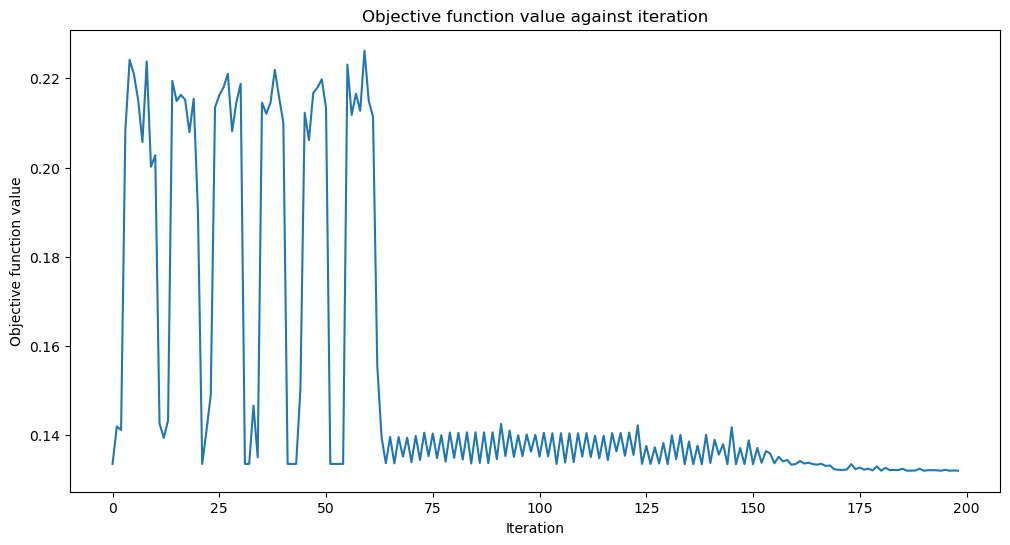

In [ ]:
#lr=0.01
#p=lr*10
#initial_point = [np.random.uniform(-2*np.pi, 2*np.pi, 60)]
#opt = SPSA(maxiter=10, learning_rate=lr, perturbation=p, blocking=True)
opt = COBYLA(maxiter=200)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=loss_func_fashion, x0=initial_point) #, bounds=[(0, 1)])
opt_result_x = opt_result.x
elapsed = time.time() - start
print(f"Fit in {elapsed/3600:0.4f} HS")

In [ ]:
with open("QAE_IP.json", "w") as file:
     json.dump(opt_result_x.tolist(), file)

### Test

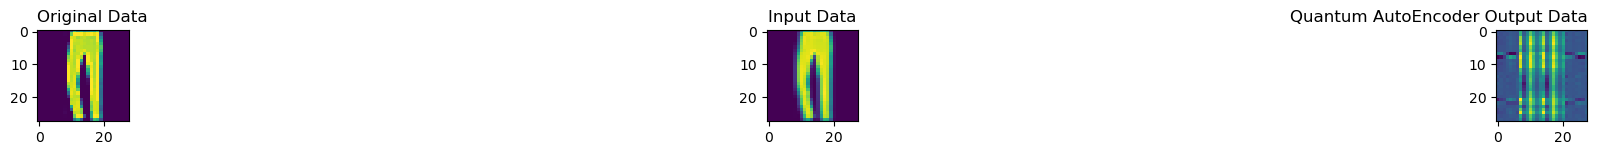

Fidelity of our Output State with our Input State:0.677
Qiskit built-in Fidelity of our Output State with our Input State:0.458



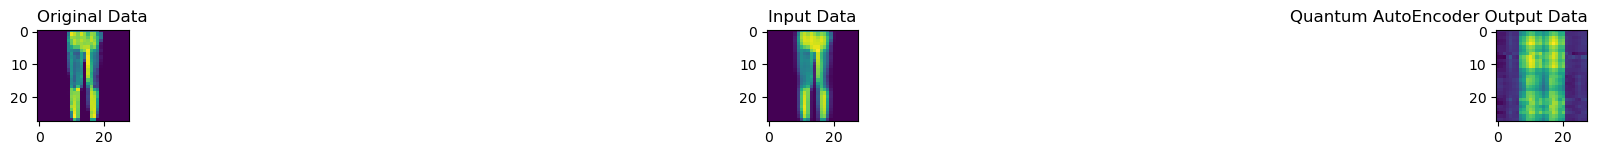

Fidelity of our Output State with our Input State:0.792
Qiskit built-in Fidelity of our Output State with our Input State:0.627



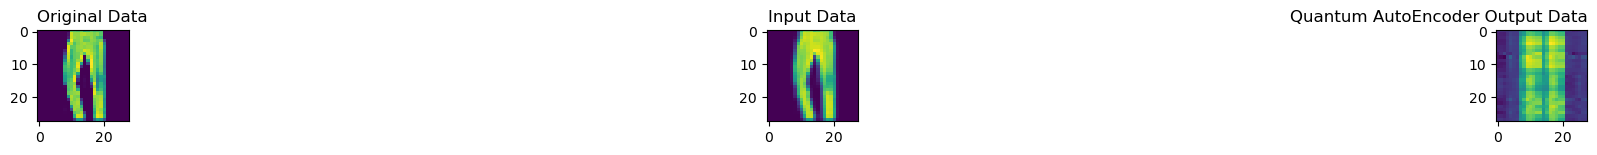

Fidelity of our Output State with our Input State:0.876
Qiskit built-in Fidelity of our Output State with our Input State:0.768



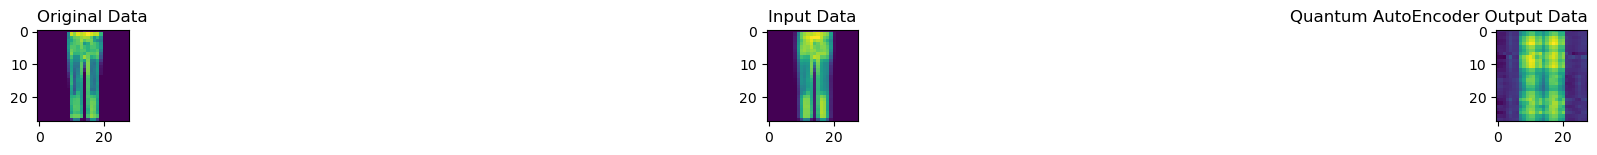

Fidelity of our Output State with our Input State:0.838
Qiskit built-in Fidelity of our Output State with our Input State:0.702



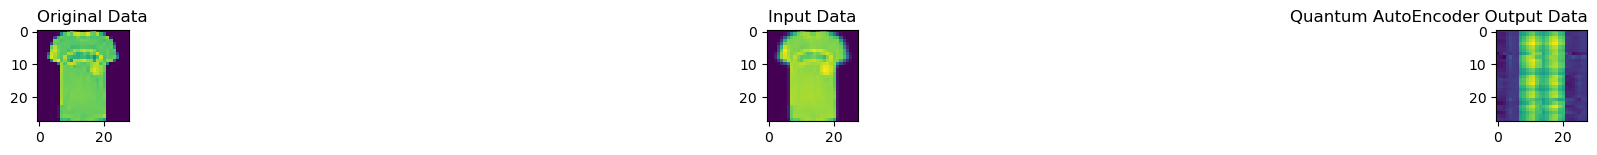

Fidelity of our Output State with our Input State:0.935
Qiskit built-in Fidelity of our Output State with our Input State:0.875



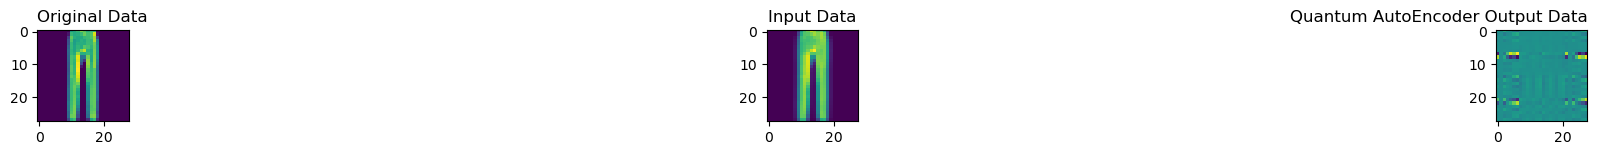

Fidelity of our Output State with our Input State:0.042
Qiskit built-in Fidelity of our Output State with our Input State:0.002



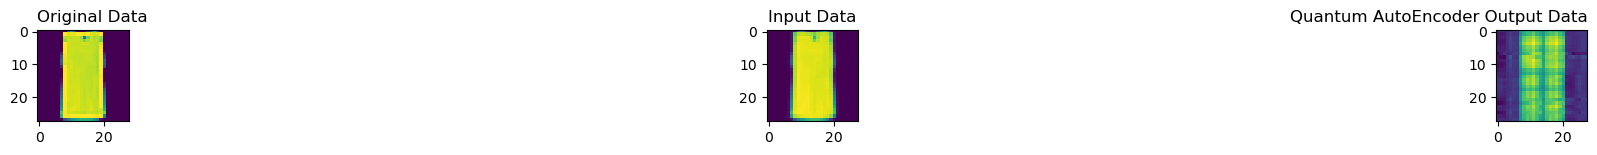

Fidelity of our Output State with our Input State:0.952
Qiskit built-in Fidelity of our Output State with our Input State:0.906



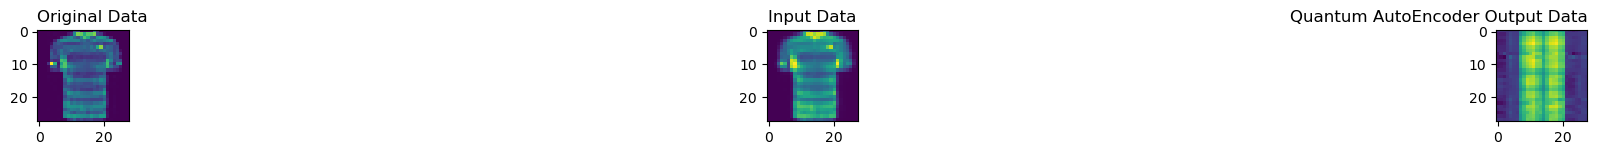

Fidelity of our Output State with our Input State:0.864
Qiskit built-in Fidelity of our Output State with our Input State:0.746



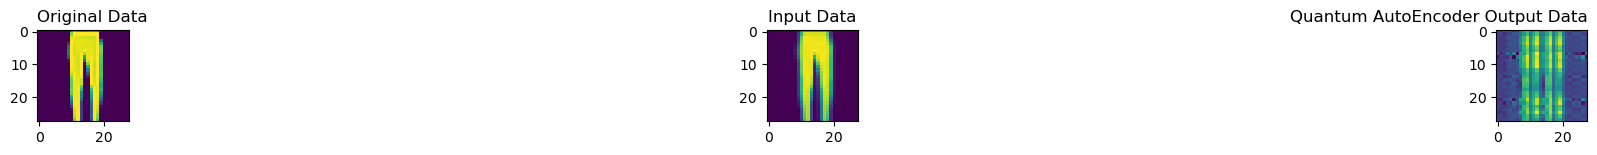

Fidelity of our Output State with our Input State:0.646
Qiskit built-in Fidelity of our Output State with our Input State:0.417



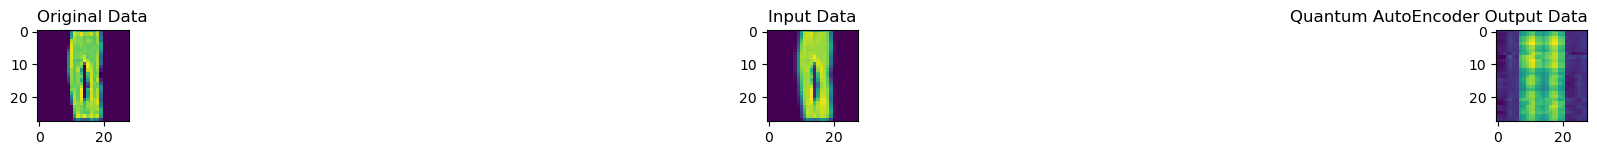

Fidelity of our Output State with our Input State:0.856
Qiskit built-in Fidelity of our Output State with our Input State:0.732



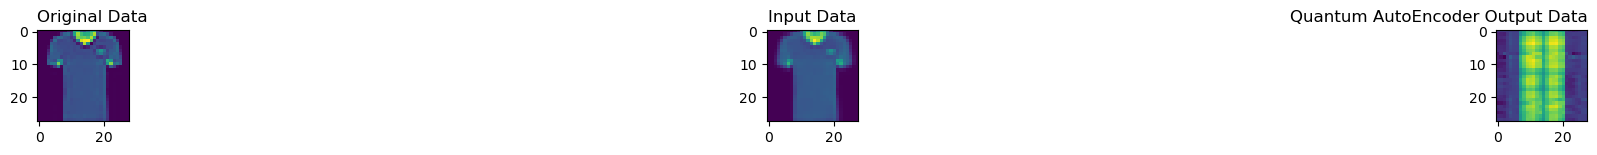

Fidelity of our Output State with our Input State:0.824
Qiskit built-in Fidelity of our Output State with our Input State:0.678



In [151]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(9)
test_qc.reset(8)
test_qc.reset(7)
test_qc.reset(6)
test_qc.reset(5)
test_qc.reset(4)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())


# sample new images
c = 0
test_images = X_test_resized_reshaped[0:11]
for image in test_images: 
    #input data   
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original = cv2.resize(original_sv.real.reshape(
        1, -1).reshape(32, 32), (28, 28), interpolation=cv2.INTER_LINEAR_EXACT)
    #VAQ Output Data
    param_values = np.concatenate((image, opt_result_x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output = cv2.resize(output_sv.real.reshape(
        1, -1).reshape(32, 32), (28, 28), interpolation=cv2.INTER_LINEAR_EXACT)
    #Plotting Transformations
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    fig.subplots_adjust(wspace=7)
    ax1.imshow(X_test[c])
    ax1.set_title("Original Data", loc="left")
    ax2.imshow(original)
    ax2.set_title("Input Data", loc="center")
    ax3.imshow(output)
    ax3.set_title("Quantum AutoEncoder Output Data", loc="right")
    plt.show()
    fidelity = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
    print(f"Fidelity of our Output State with our Input State:{fidelity.real:0.3f}")
    print(f"Qiskit built-in Fidelity of our Output State with our Input State:{state_fidelity(original_sv, output_sv):0.3f}\n")
    c += 1


<b> In general, we have acceptable fidelities </b>

# Quantum Convolutional Neural Network

We are going to take advantage of the QAE and code a QCNN to binary classify the labels 0 and 1 from the fashion MNIST dataset

In [214]:
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN


### Convolutional Layer

In [215]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

In [216]:
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)


In [ ]:
circuit.draw("mpl")

In [217]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


In [218]:
circuit = conv_layer(4, "θ")

In [ ]:
circuit.decompose().draw("mpl")

### Pooling Layer

In [219]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

In [220]:
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)

In [ ]:
circuit.draw("mpl")

In [221]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [222]:
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")

In [ ]:
circuit.decompose().draw("mpl")

In [223]:
Ansatz = QuantumCircuit(4, name="Ansatz")

# First Convolutional Layer
Ansatz.compose(conv_layer(4, "с1"), list(range(4)), inplace=True)

# First Pooling Layer
Ansatz.compose(pool_layer([0, 1],[2, 3],
               "p1"), list(range(4)), inplace=True)

# Second Convolutional Layer
Ansatz.compose(conv_layer(2, "c2"), list(range(2, 4)), inplace=True)

# Second Pooling Layer
Ansatz.compose(pool_layer([0], [1], "p2"),
               list(range(2, 4)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(4)

circuit.compose(Ansatz, range(4), inplace=True)

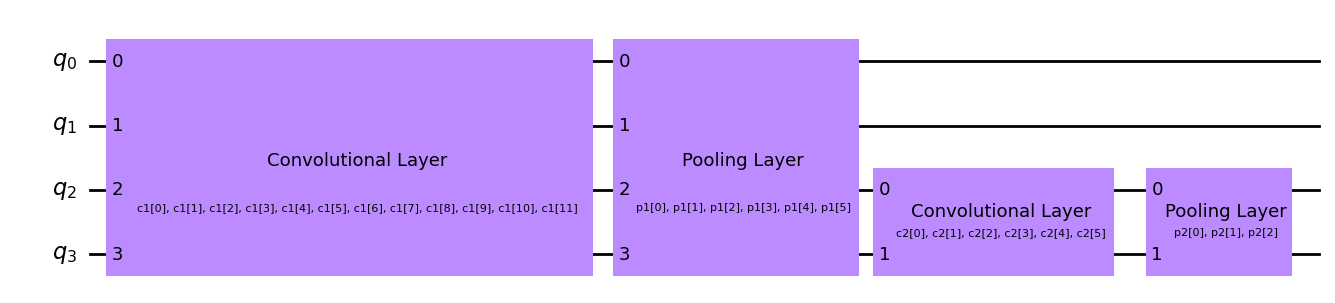

In [229]:
circuit.draw('mpl')

### New AutoEnocer circuit with ansatz optimal results binded

In [224]:
fm = RawFeatureVector(2 **(num_latent + num_trash))
ae = ansatz(10)

qc = QuantumCircuit(10)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae.bind_parameters(opt_result_x))


In [225]:
full_circuit = qc.compose(circuit)


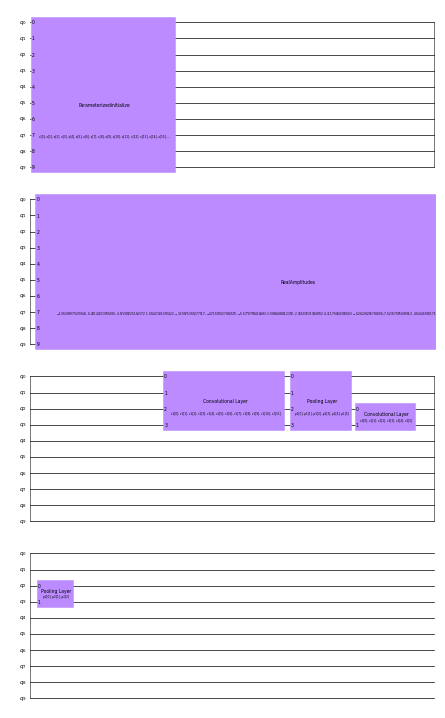

In [228]:
full_circuit.draw("mpl", scale=0.25) 

In [230]:
observable = SparsePauliOp.from_list([("I"*6 + "Z" + "I" * 3, 1)])

qnn = EstimatorQNN(
    circuit=full_circuit,
    observables=observable,
    input_params=fm.parameters,
    weight_params=Ansatz.parameters,
)

In [231]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [256]:
with open("QCNN_IP.json", "r") as f:
    initial_point = json.load(f)

### Classifier Definition

In [257]:
#initial_point = [np.random.uniform(-2*np.pi, 2*np.pi, 27)]

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

In [258]:
x = np.asarray(X_train_resized_reshaped[0:100])
y = np.asarray(Y_train[0:100], dtype='float')

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1

In [ ]:
### 

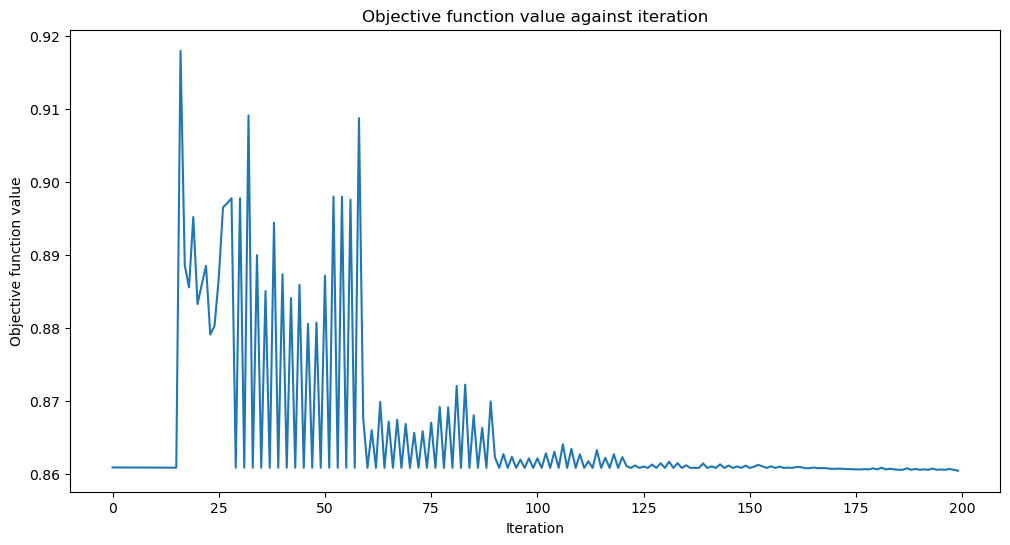

In [259]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

In [260]:
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the train data : 64.0%


In [261]:
with open("QCNN_IP.json", "w") as file:
     json.dump(classifier.weights.tolist(), file)